In [1]:
install.packages(c("tidyverse", "igraph","maps",
    "quanteda", "quanteda.textplots", 
    "quanteda.textstats", "topicmodels"))

In [2]:
library(tidyverse)
library(lubridate)
library(quanteda)
library(quanteda.textplots)
library(quanteda.textstats)
library(topicmodels)
library(igraph)
library(maps)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Package version: 3.0.0
Unicode version: 13.0
ICU version: 66.1

Parallel computing: 8 of 8 threads used.

See https://quanteda.io for tutorials and examples.


Attaching package: ‘igraph’


The following object is masked fr

In [3]:
tw = read_csv("https://cssbook.net/d/covid.csv")
head(tw)


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  status_id = col_double(),
  created_at = col_datetime(format = ""),
  screen_name = col_character(),
  lang = col_character(),
  location = col_character(),
  text = col_character(),
  retweet_count = col_double(),
  reply_to_screen_name = col_character()
)




status_id,created_at,screen_name,lang,location,text,retweet_count,reply_to_screen_name
<dbl>,<dttm>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
1.309536e+18,2020-09-25 16:50:33,ghulamabbasshah,en,"Lahore, Pakistan",Secularism of #Gandhi and #Nehru in #India has been replaced by #RSS #Hindutva . #Muslims falsely blame &amp; victimized for spreading #covid #RSS is an organisation that promotes #Islamophobia India is the only country that witnessed state sponsored Islamophobia. says #ImranKhan https://t.co/HZZEgvBzyW,1203,NA
1.309626e+18,2020-09-25 22:49:07,GeoRebekah,en,"Florida, USA","On the day @GovRonDeSantis rejects the experts and all reason by forcing Florida into Phase III, a 12 year old girl from Atlantic Beach lost her battle with #COVID and died. She was in the sixth grade. Just started school back to at Mayport in Duval. #ThisIsThePrice",1146,NA
1.309578e+18,2020-09-25 19:39:16,AlexBerenson,en,New York,"Updated @cgcgov figures: 66 children under 15 have died from/with #Covid since February. 16,761 have died of other causes. Fewer than 1 in 250 child deaths are related to #Covid in any way. https://t.co/lGT3osyDOg",988,NA
1.309558e+18,2020-09-25 18:18:22,AlexBerenson,en,New York,No mo ro in Flo: @govrondesantis proves again he gets the science and is the best big-state governor on #Covid by not just lifting all restrictions but stopping cities and counties from enforcing their own nonsense. Say it with me: WAAAAIT TWO WEEKS! https://t.co/E4BMxtdIT8,953,NA
1.309643e+18,2020-09-25 23:57:22,B52Malmet,en,"New York, NY","Dr. Fauci warns the worst public health crisis in our lifetime is not what we are going through now, but what is coming in the fall and winter. Keep your laser focus on staying safe, masking up, preparing for #covid winter. Stay strong. Stay well. Only 1st🦵of a marathon.",946,NA
1.309772e+18,2020-09-26 08:28:51,iingwen,en,Taipei City,It’s great to have a genuine friend like #Nauru! Thank you President Aingimea for speaking up for #Taiwan’s rights at #UN75 &amp; telling the world about what we have to offer when it comes to responding to global issues like #COVID. https://t.co/lLb90TiCKH,436,NA


In [4]:
options(tibble.width=120, width=120)
print(tw, n=3)

# A tibble: 9,811 x 8
  status_id created_at          screen_name  lang  location   text                        retweet_count reply_to_screen…
      <dbl> <dttm>              <chr>        <chr> <chr>      <chr>                               <dbl> <chr>           
1   1.31e18 2020-09-25 16:50:33 ghulamabbas… en    Lahore, P… "Secularism of #Gandhi and…          1203 NA              
2   1.31e18 2020-09-25 22:49:07 GeoRebekah   en    Florida, … "On the day @GovRonDeSanti…          1146 NA              
3   1.31e18 2020-09-25 19:39:16 AlexBerenson en    New York   "Updated @cgcgov figures: …           988 NA              
# … with 9,808 more rows


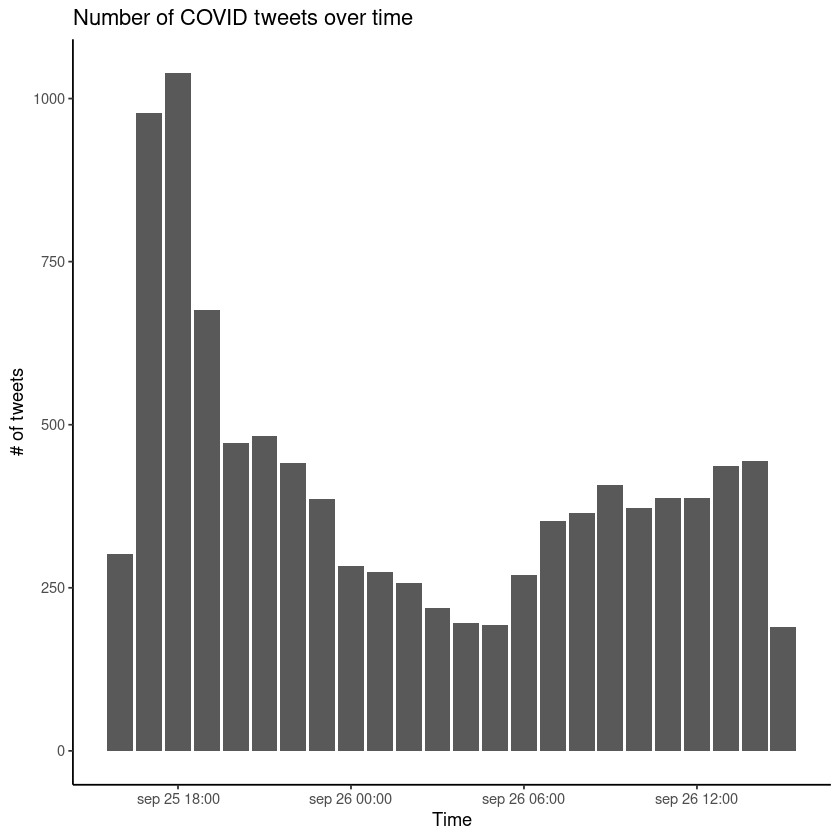

In [5]:
tweets_per_hour = tw %>% 
  mutate(hour=round_date(created_at, "hour")) %>% 
  group_by(hour) %>% summarize(n=n()) 
ggplot(tweets_per_hour, aes(x=hour, y=n)) + 
  geom_col() + theme_classic() + 
  xlab("Time") + ylab("# of tweets") +
  ggtitle("Number of COVID tweets over time")

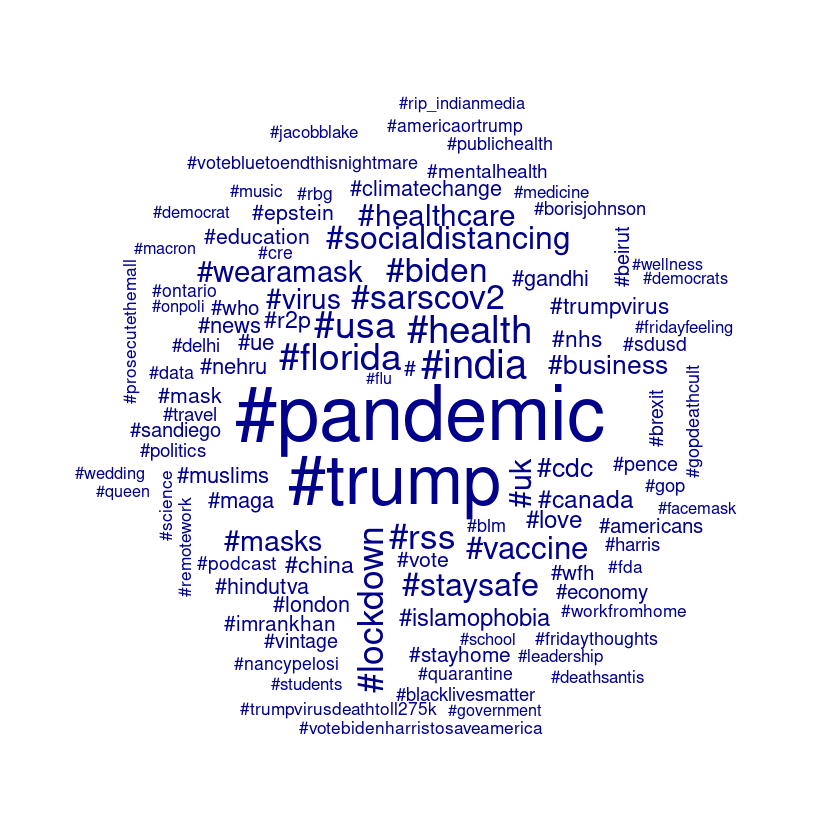

In [6]:
dtm_tags = filter(tw, lang=="en") %>% 
  corpus() %>% tokens() %>% 
  dfm(tolower = T) %>% 
  dfm_select(pattern = "#*") %>% 
  dfm_remove(c(stopwords("en"), 
                      "#corona*", "#covid*")) 
textplot_wordcloud(dtm_tags, max_words=100)

In [7]:
set.seed(123)
m = convert(dtm_tags, to="topicmodel") %>% 
  LDA(10, method="Gibbs")
terms(m, 5)

Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
#health,#pandemic,#florida,#wfh,#pandemic,#sarscov2,#trump,#india,#trumpvirus,#vaccine
#healthcare,#masks,#staysafe,#sdusd,#canada,#business,#usa,#rss,#trump,#china
#maga,#virus,#socialdistancing,#pandemic,#podcast,#economy,#biden,#islamophobia,#climatechange,#lockdown
#vote,#pence,#lockdown,#workfromhome,#leadership,#wearamask,#uk,#gandhi,#americans,#education
#wearamask,#mask,#love,#remotework,#music,#rip_indianmedia,#r2p,#nehru,#gopdeathcult,#delhi



── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  screen_name = col_character(),
  location = col_character(),
  lat = col_double(),
  long = col_double()
)


Joining, by = c("screen_name", "location")

Warning message:
“Removed 3371 rows containing missing values (geom_point).”


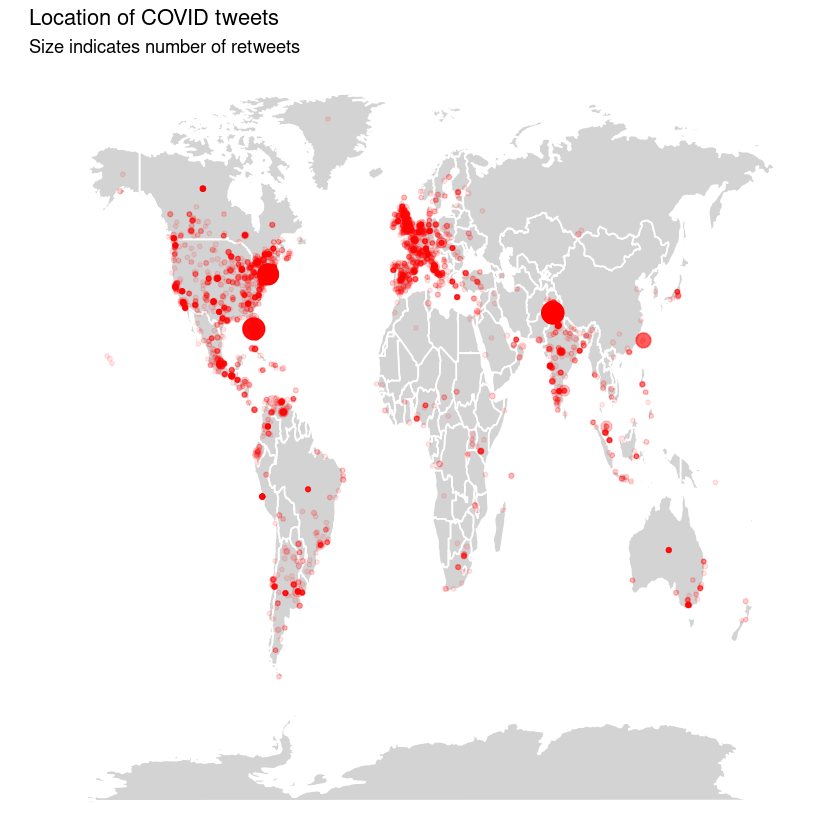

In [8]:
url = "https://cssbook.net/d/covid_users.csv"
users = read_csv(url)
tw2 = left_join(tw, users)
ggplot(mapping=aes(x=long, y=lat)) +
  geom_polygon(aes(group=group), 
    data=map_data("world"), 
    fill="lightgray", colour = "white") +
  geom_point(aes(size=retweet_count, 
                 alpha=retweet_count), 
             data=tw2, color="red") + 
  theme_void() + theme(aspect.ratio=1) + 
  guides(alpha=FALSE, size=FALSE) + 
  ggtitle("Location of COVID tweets", 
          "Size indicates number of retweets")

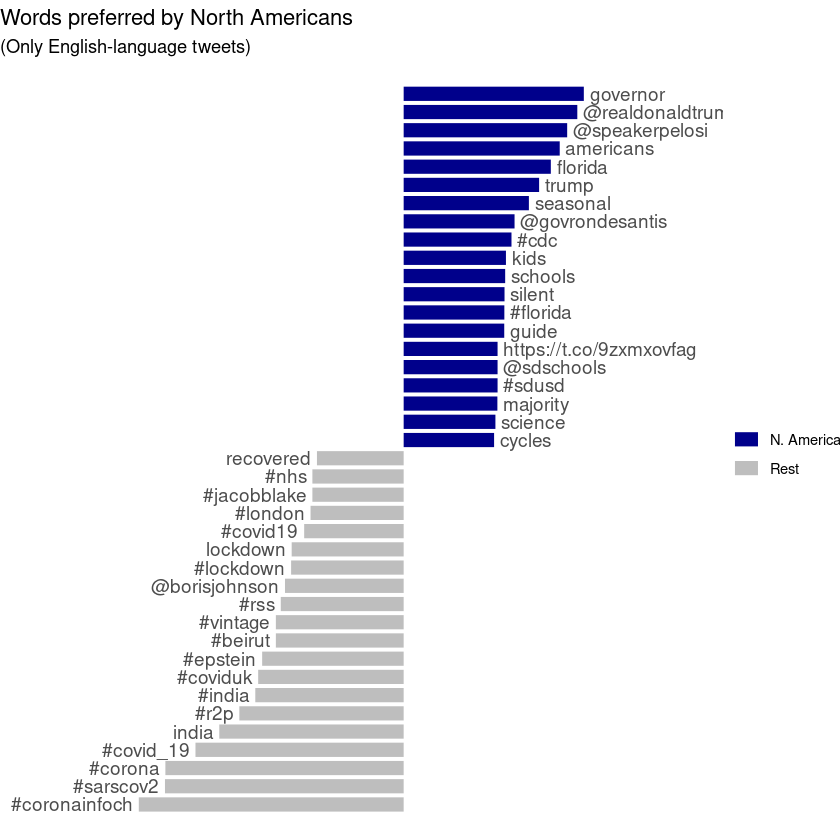

In [9]:
dfm = tw2 %>% mutate(northamerica=ifelse(
    long < -60 & lat > 25,"N. America","Rest"))%>%
  filter(lang=="en") %>% 
  corpus(docid_field="status_id") %>% 
  tokens(remove_punct=T) %>%
  tokens_group(northamerica) %>%
  dfm(tolower=T) %>% 
  dfm_remove(stopwords("en")) %>%
  dfm_select(min_nchar=4)
key = textstat_keyness(dfm, target="N. America")
textplot_keyness(key, margin=0.2) +
  ggtitle("Words preferred by North Americans", 
          "(Only English-language tweets)") + 
  theme_void()


In [10]:
edges = tw2 %>% 
  select(from=screen_name, 
         to=reply_to_screen_name) %>% 
  filter(to != "") %>%
  group_by(to, from) %>% 
  summarize(n=n())
head(edges)

`summarise()` has grouped output by 'to'. You can override using the `.groups` argument.



to,from,n
<chr>,<chr>,<int>
_FutureIsUs,_FutureIsUs,1
_JaylaS_,AfronerdRadio,1
_LoveMTB_,ExpatriateNl,1
_nogueiraneto,ideobisium,1
_NotFakeNews_,panich52,1
_vikasupadhyay,SHADABMOHAMMAD7,4


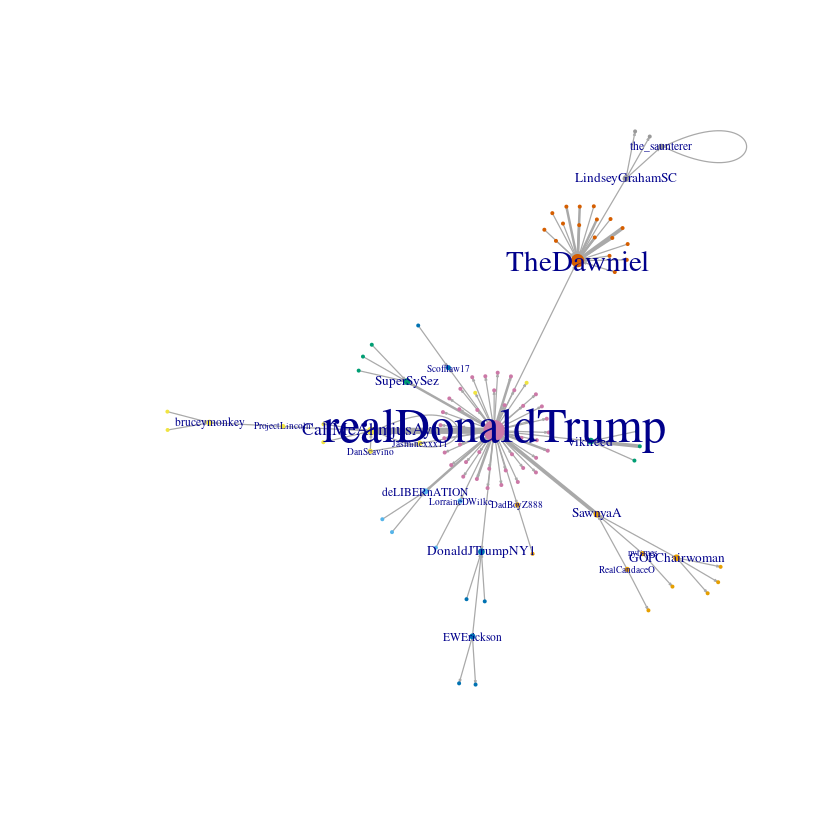

In [11]:
# create igraph and select largest component
g = graph_from_data_frame(edges)
components <- decompose.graph(g)
largest = which.max(sapply(components, gsize))
g2 = components[[largest]]
# Color nodes by cluster
clusters = cluster_spinglass(g2)
V(g2)$color = clusters$membership
V(g2)$frame.color = V(g2)$color
# Set node (user) and edge (arrow) size
V(g2)$size = degree(g2)^.5
V(g2)$label.cex = V(g2)$size/3
V(g2)$label = ifelse(degree(g2)<=1,"",V(g2)$name) 
E(g2)$width = E(g2)$n
E(g2)$arrow.size= E(g2)$width/10
plot(g2)

Warning message:
“Removed 3371 rows containing missing values (geom_point).”


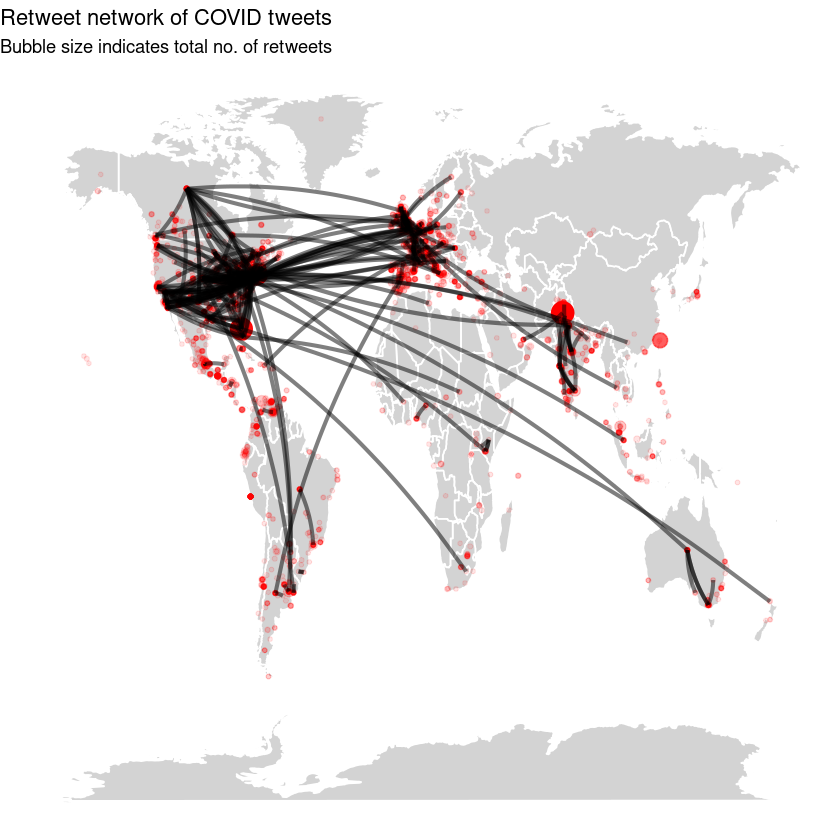

In [12]:
edges2 = edges %>% 
  inner_join(users, by=c("from"="screen_name"))%>%
  inner_join(users, by=c("to"="screen_name"), 
             suffix=c("", ".to")) %>% 
  filter(lat != lat.to | long != long.to )
ggplot(mapping=aes(x = long, y = lat)) +
  geom_polygon(aes(group=group),map_data("world"),
    fill="lightgray", colour = "white") +
  geom_point(aes(size=retweet_count, 
  alpha=retweet_count), data=tw2, color="red")+
  geom_curve(aes(xend=long.to,yend=lat.to,size=n),
             edges2, curvature=.1, alpha=.5) +
  theme_void() + guides(alpha=FALSE, size=FALSE) +
  ggtitle("Retweet network of COVID tweets", 
  "Bubble size indicates total no. of retweets")